<a href="https://colab.research.google.com/github/lucckkas/MachineLearning/blob/main/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final - Machine Learning

- **Autor:** Luckas Strnad Alvarez

## 1. Problema
Los datos proporcionados tienen un origen no revelado,
pero corresponden a una aplicación real en el campo de la
ingeniería. El problema consiste en encontrar un modelo
de regresión para predecir de manera efectiva la variable
dependiente

## 2. Hipótesis
 Existe una relación lineal significativa entre un conjunto seleccionado de variables independientes y la variable dependiente, que puede ser modelada efectivamente mediante un modelo de regresión lineal o no lineal. Este modelo proporcionará una precisión predictiva razonable, superando un umbral mínimo preestablecido de rendimiento, en este proyecto se utilizará el error cuadrático medio (MSE) como métrica de rendimiento, buscando un MSE menor a 0.5.

## 3. Datos
Los datos se descargaron del enlace proporcionado en el enunciado (https://goo.gl/64CUV7) y se guardaron como un archivo csv en la carpeta data del proyecto, con el nombre de `data.csv`.

Carga de datos y librerías necesarias para el proyecto:

Para instalar las librerías necesarias para el proyecto, ejecutar los siguientes comandos:

In [ ]:
import sys
import subprocess
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'numpy'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pandas'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-learn'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'seaborn'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tensorflow'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikeras'])

0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
# debido a que no me funcino tensorflow.keras.wrappers.scikit_learn.KerasRegressor use scikeras.wrappers.KerasRegressor
# pero este ultimo tiene warnings que oculte para que no ofusquen la salida del programa
import warnings
warnings.filterwarnings('ignore')
# cargar data.csv
dataset = pd.read_csv('data.csv')


## 4. Preprocesamiento de datos
Se realiza un preprocesamiento de los datos para eliminar los valores nulos y los valores atípicos, además de realizar una normalización de los datos para que todos los valores estén en el mismo rango.
El dataset tiene no tiene datos faltantes ni categoricos en este caso, por lo que no hay que hacer nada en ese sentido.

Detección de datos atípicos

In [ ]:
def remove_outliers(df, max_outliers_percent=5):
    max_outliers = int(len(df) * max_outliers_percent / 100)

    # Lista para almacenar las desviaciones temporales
    deviations = []

    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calcular la desviación de la norma para cada fila
        deviation = np.maximum(np.abs(df[column] - lower_bound), np.abs(df[column] - upper_bound))
        deviations.append(deviation)

    # Crear un DataFrame a partir de las desviaciones y calcular la puntuación de anomalía
    df_deviations = pd.concat(deviations, axis=1)
    df_deviations["anomaly_score"] = df_deviations.sum(axis=1)

    outliers_indices = df_deviations["anomaly_score"].nlargest(max_outliers).index
    df_cleaned = df.drop(outliers_indices)
    return df_cleaned
dataset = remove_outliers(dataset)

Normalización

In [ ]:
# Normalizar los datos Z-score
sc = StandardScaler()
dataset_normalizado = pd.DataFrame(sc.fit_transform(dataset), columns=dataset.columns)

## 5. Visualización de datos y Reducción de dimensionalidad
Para visualizar los datos se utilizó PCA para reducir la dimensionalidad de los datos a 4 dimensiones y poder graficarlos en un plano cartesiano.

In [ ]:
X = dataset_normalizado.drop('Y', axis=1)
y = dataset['Y']
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

varianza_explicada = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:", varianza_explicada)
print("Varianza acumulada:", np.cumsum(varianza_explicada))


Varianza explicada por cada componente: [0.91902052 0.02965405 0.01153221 0.00566592]
Varianza acumulada: [0.91902052 0.94867456 0.96020678 0.96587269]


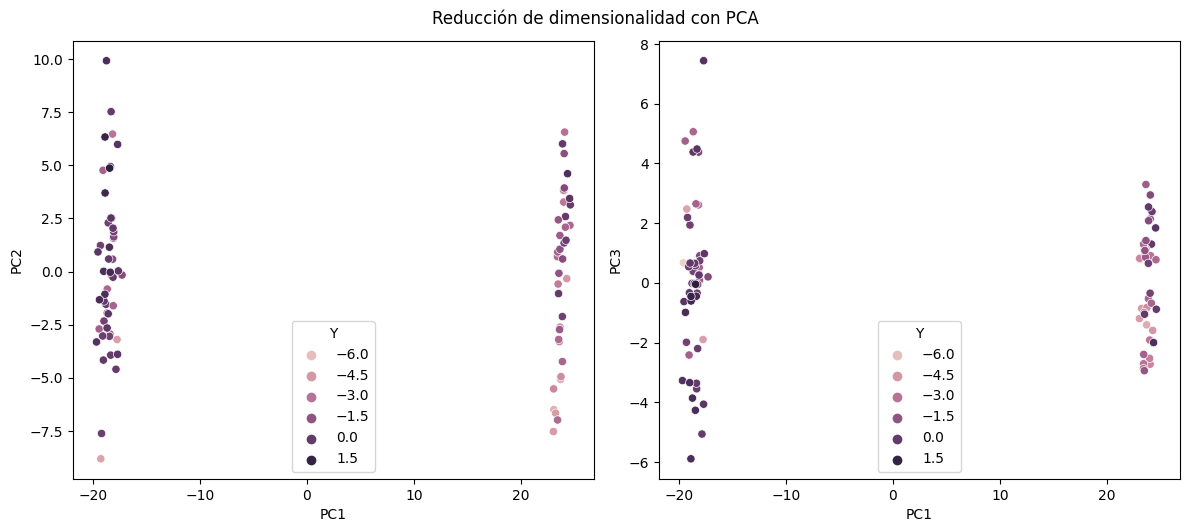

In [ ]:
plt.figure(figsize=(12, 10))

# Componente 1 vs Componente 2
plt.subplot(2, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y)
plt.xlabel('PC1')
plt.ylabel('PC2')

# Componente 1 vs Componente 3
plt.subplot(2, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 2], hue=y)
plt.xlabel('PC1')
plt.ylabel('PC3')


plt.suptitle('Reducción de dimensionalidad con PCA')
plt.tight_layout()
plt.show()


## 6. Regresión

In [ ]:
model_lineal = LinearRegression()
model_lineal.fit(X_pca, y)

def build_model():
    model_neuronal = tf.keras.models.Sequential()
    model_neuronal.add(tf.keras.layers.Dense(64, input_dim=X_pca.shape[1], activation='relu'))  # Capa de entrada
    model_neuronal.add(tf.keras.layers.Dense(32, activation='relu'))  # Capa oculta
    model_neuronal.add(tf.keras.layers.Dense(1, activation='linear'))  # Capa de salida
    model_neuronal.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model_neuronal

# Envuelve el modelo de Keras para que sea compatible con scikit-learn
model_neuronal = KerasRegressor(build_fn=build_model, epochs=100, batch_size=10, verbose=0)

# Entrenar el modelo
history = model_neuronal.fit(X_pca, y, epochs=100, batch_size=10, verbose=0, validation_split=0.2)


## 7. Medidas de desempeño
Para medir el desempeño del modelo se utilizó el error cuadrático medio (MSE) y el coeficiente de determinación (R2).

La formula del MSE es la siguiente: $$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2$$

La formula del R2 es la siguiente: $$R^2 = 1 - \frac{\sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2}{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}$$

Donde $Y_i$ es el valor real, $\hat{Y}_i$ es el valor predicho, $\bar{Y}$ es el promedio de los valores reales y $n$ es el número de datos.

## 8. Validación
Para validar el modelo se utilizó la técnica de validación cruzada con 10 folds, donde se dividen los datos en 10 partes iguales, se entrena el modelo con 9 partes y se prueba con la parte restante, esto se repite 10 veces, de tal manera que todas las partes se utilizan para entrenar y probar el modelo.

In [ ]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)

# Validación cruzada para el modelo de regresión lineal
scores_lineal = cross_validate(model_lineal, X_pca, y, scoring=['neg_mean_squared_error', 'r2'], cv=cv)
# Validación cruzada para el modelo de red neuronal
scores_neuronal = cross_validate(model_neuronal, X_pca, y, scoring=['neg_mean_squared_error', 'r2'], cv=cv)

mse_lineal = np.abs(scores_lineal['test_neg_mean_squared_error'].mean())
r2_lineal = scores_lineal['test_r2'].mean()

mse_neuronal = np.abs(scores_neuronal['test_neg_mean_squared_error'].mean())
r2_neuronal = scores_neuronal['test_r2'].mean()

print("Regresión Lineal")
print(f"Mean Squared Error: {mse_lineal}")
print(f"R^2 Score: {r2_lineal}")

print("Red Neuronal")
print(f"Mean Squared Error: {mse_neuronal}")
print(f"R^2 Score: {r2_neuronal}")


Regresión Lineal
Mean Squared Error: 2.709692889753321
R^2 Score: 0.06105962755413097
Red Neuronal
Mean Squared Error: 2.9078664246810026
R^2 Score: -0.052024114578922385


## 9. Resultados
Los resultados obtenidos fueron los siguientes:

Text(0.5, 1.0, 'Red Neuronal')

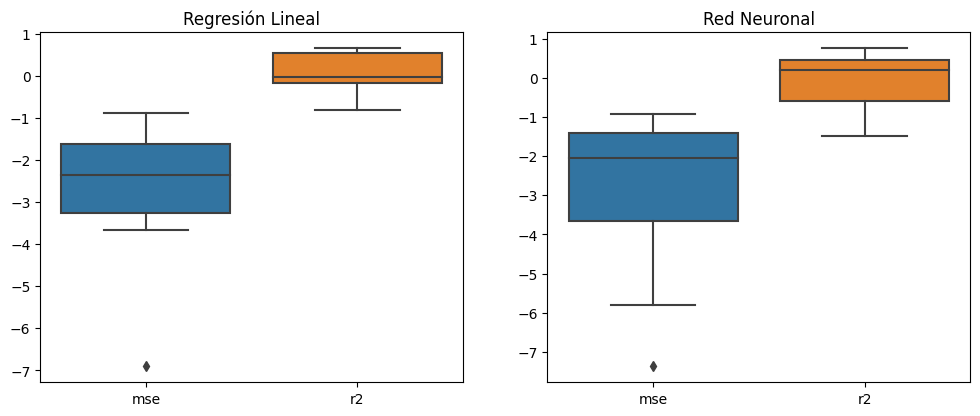

In [ ]:
scores_lineal.pop('fit_time')
scores_lineal.pop('score_time')
scores_lineal['mse'] = scores_lineal.pop('test_neg_mean_squared_error')
scores_lineal['r2'] = scores_lineal.pop('test_r2')

scores_neuronal.pop('fit_time')
scores_neuronal.pop('score_time')
scores_neuronal['mse'] = scores_neuronal.pop('test_neg_mean_squared_error')
scores_neuronal['r2'] = scores_neuronal.pop('test_r2')

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
sns.boxplot(data=pd.DataFrame(scores_lineal))
plt.title('Regresión Lineal')

plt.subplot(2, 2, 2)
sns.boxplot(data=pd.DataFrame(scores_neuronal))
plt.title('Red Neuronal')


## 10. Conclusiones
Performance de los Modelos: Ambos modelos, la Regresión Lineal y la Red Neuronal, muestran una mediana de error cuadrático medio (mse) en un rango similar, lo que sugiere que en términos de mse, su rendimiento es comparable. Sin embargo, la distribución más compacta de los mse en la Red Neuronal puede indicar una consistencia ligeramente mejor en las predicciones de ese modelo en comparación con la Regresión Lineal.

Consistencia en la Varianza Explicada: Con respecto al coeficiente de determinación R cuadrado (r2), ambos modelos exhiben medianas cercanas a 0, lo cual podría ser indicativo de que ninguno de los dos modelos es particularmente fuerte en explicar la varianza de la variable dependiente. Sin embargo, la distribución del r2 en la Red Neuronal es ligeramente menos variada, lo que podría interpretarse como una mayor consistencia en la proporción de varianza explicada por este modelo.

Elección del Modelo: La selección entre la Regresión Lineal y la Red Neuronal debería basarse no solo en estos resultados estadísticos, sino también en consideraciones prácticas como la complejidad del modelo, el tiempo de entrenamiento, la interpretabilidad y el costo computacional. Si el rendimiento es similar, la Regresión Lineal podría ser preferida por su simplicidad y facilidad de interpretación. Por otro lado, si se espera que la relación entre las variables sea no lineal, la Red Neuronal podría ser más adecuada a pesar de su mayor complejidad.

Interpretación del r2 Negativo: Es importante mencionar que los valores de r2 negativos son posibles y sugieren que el modelo es inadecuado, con un ajuste peor que un modelo muy simple que simplemente predijera la media de la variable dependiente. Esto podría ser un indicador de que se requiere una revisión del modelo o una selección de características más cuidadosa.

En resumen, mientras que la Red Neuronal puede ofrecer una consistencia ligeramente mejor en sus predicciones, ninguno de los dos modelos destaca en explicar una gran proporción de la varianza en los datos, lo que indica la necesidad de una evaluación más profunda o la consideración de otros modelos o técnicas de modelado. Una posible explicación de este resultado es que la relación entre las variables independientes y la variable dependiente no es lineal, lo que podría requerir un modelo más complejo para capturarla adecuadamente, o algun error al momento de realizar el preprocesamiento de los datos o la reducción de dimensionalidad.